# Country Economic Conditions for Cargo Carriers (Machine Learning with Classification Models)

This report is written from the point of view of a data scientist preparing a report to the Head of Analytics for a logistics company. The company needs information on economic and financial conditions is different countries, including data on their international trade, to be aware of any situations that could affect business.

## Objective

The objective of this report is to determine what factors may be driving investment in a country. For our company, it is important to understand the drivers of global growth and investment, as it allows us to plan ahead for where there may be greater demand for cargo services in the future. We want to positions ourselves as the go-to logistics company globally. Positioning ourselves in growing trade hubs will serve the long-term strategic objectives of our global services.

## Data Summary

This dataset is taken from the International Monetary Fund (IMF) data bank. It lists country-level economic and financial statistics from all countries globally. This includes data such as gross domestic product (GDP), inflation, exports and imports, and government borrowing and revenue. The data is given in either US Dollars, or local currency depending on the country and year. Some variables, like inflation and unemployment, are given as percentages.

## Data Exploration

In [12]:
#Import required packages
import numpy as np
import pandas as pd
from sklearn import linear_model
from scipy import stats 
from numpy import *
from scipy.stats.mstats import normaltest
import math
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

In [13]:
#Import IMF World Economic Outlook Data from GitHub
WEO = pd.read_csv('https://raw.githubusercontent.com/jamiemfraser/machine_learning/main/WEOApr2021all.csv')
WEO=pd.DataFrame(WEO)
WEO.head()

,CountryCode,Country,Indicator,Notes,Units,Scale,2000,2001,2002,2003,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,AFG,Afghanistan,Current account balance,Current account is all transactions other than...,U.S. dollars,Billions,NaN,NaN,1.481,1.348,...,4.510,4.754,2.205,0.291,1.353,0.768,1.623,1.434,2.237,2.209
1,AFG,Afghanistan,Current account balance,Current account is all transactions other than...,Percent of GDP,NaN,NaN,NaN,33.908,29.616,...,29.430,26.574,10.864,1.444,6.557,3.796,9.018,7.586,12.158,11.705
2,ALB,Albania,Current account balance,Current account is all transactions other than...,U.S. dollars,Billions,-0.246,-0.248,-0.443,-0.432,...,-1.351,-1.666,-1.257,-1.183,-1.430,-0.981,-0.898,-0.978,-1.024,-1.219
3,ALB,Albania,Current account balance,Current account is all transactions other than...,Percent of GDP,NaN,-7.070,-6.315,-10.179,-7.695,...,-11.321,-12.917,-10.202,-9.253,-10.797,-8.609,-7.572,-7.492,-6.758,-7.979
4,DZA,Algeria,Current account balance,Current account is all transactions other than...,U.S. dollars,Billions,9.142,7.060,4.359,8.808,...,12.157,19.802,12.290,0.835,-9.436,-27.290,-26.473,-22.081,-16.706,-17.150


In [14]:
#We are only interested in the most recent year for which data is available, 2019
WEO=WEO.drop(['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'], axis = 1)

#Reshape the data so each country is one observation
WEO=WEO.pivot_table(index=["Country"], columns='Indicator', values='2019').reset_index()
WEO.dropna(inplace=True)
WEO.head()

Indicator,Country,Current account balance,Employment,General government net lending/borrowing,General government revenue,General government total expenditure,"Gross domestic product per capita, constant prices","Gross domestic product per capita, current prices","Gross domestic product, constant prices","Inflation, average consumer prices",Total investment,Unemployment rate,Volume of exports of goods and services,Volume of imports of goods and services
8,Australia,4.9525,12.865,-40.2135,361.9895,402.2025,63894.200,61831.413333,987.3780,58.3800,22.544,5.150,3.313,-1.004
9,Austria,7.7475,4.337,1.6740,122.1255,120.4515,49263.665,51270.103333,187.7360,65.7460,25.471,4.525,2.943,2.448
15,Belgium,1.1055,4.978,-5.6135,144.3515,149.9650,45417.555,47458.873333,222.9465,54.5075,24.952,5.358,-0.079,-0.719
30,Canada,-18.8820,18.979,6.4965,500.1590,493.6625,52701.355,53147.910000,1052.0805,68.9660,22.988,5.733,1.267,0.346
39,Cyprus,-3.9415,0.416,0.8970,25.3930,24.4965,32609.890,32056.303333,12.3540,50.6670,19.687,7.075,-0.408,1.951


In [15]:
WEO.columns = ['Country', 'Current_account', 'Employment', 'Net_borrowing', 'Government_revenue', 'Government_expenditure', 'GDP_percap_constant', 'GDP_percap_current', 'GDP_constant', 'Inflation', 'Investment', 'Unemployment', 'Volume_exports', 'Volume_imports']
WEO.head()

,Country,Current_account,Employment,Net_borrowing,Government_revenue,Government_expenditure,GDP_percap_constant,GDP_percap_current,GDP_constant,Inflation,Investment,Unemployment,Volume_exports,Volume_imports
8,Australia,4.9525,12.865,-40.2135,361.9895,402.2025,63894.200,61831.413333,987.3780,58.3800,22.544,5.150,3.313,-1.004
9,Austria,7.7475,4.337,1.6740,122.1255,120.4515,49263.665,51270.103333,187.7360,65.7460,25.471,4.525,2.943,2.448
15,Belgium,1.1055,4.978,-5.6135,144.3515,149.9650,45417.555,47458.873333,222.9465,54.5075,24.952,5.358,-0.079,-0.719
30,Canada,-18.8820,18.979,6.4965,500.1590,493.6625,52701.355,53147.910000,1052.0805,68.9660,22.988,5.733,1.267,0.346
39,Cyprus,-3.9415,0.416,0.8970,25.3930,24.4965,32609.890,32056.303333,12.3540,50.6670,19.687,7.075,-0.408,1.951


In [16]:
#Generate boolean variable for investment, indicatng whether investment is higher or lower than global mean
WEO.describe()

#Global mean for investment is 23.094944
WEO['InvestMean'] = np.where(WEO['Investment'] >=23.094944, 1, 0)
WEO = WEO.drop(["Country", "Volume_exports", "Volume_imports", "GDP_percap_current", "Government_revenue", "Government_expenditure", "Employment", "Unemployment"], axis=1)
WEO.head()

,Current_account,Net_borrowing,GDP_percap_constant,GDP_constant,Inflation,Investment,InvestMean
8,4.9525,-40.2135,63894.200,987.3780,58.3800,22.544,0
9,7.7475,1.6740,49263.665,187.7360,65.7460,25.471,1
15,1.1055,-5.6135,45417.555,222.9465,54.5075,24.952,1
30,-18.8820,6.4965,52701.355,1052.0805,68.9660,22.988,0
39,-3.9415,0.8970,32609.890,12.3540,50.6670,19.687,0


In [17]:
WEO.dtypes

Current_account        float64
Net_borrowing          float64
GDP_percap_constant    float64
GDP_constant           float64
Inflation              float64
Investment             float64
InvestMean               int64
dtype: object

<AxesSubplot:>

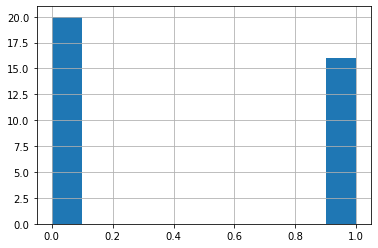

In [18]:
#Describe the distribution of InvestMean variable
WEO.InvestMean.hist()

#We now have the target variable as a boolean, where 1 = True and 0 = False, for use in classifer models

In [19]:
# Calculate the correlation values
feature_cols = WEO.columns[0:4]
corr_values = WEO[feature_cols].corr()
# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)
# Make the unused values NaNs
for coord in zip(*tril_index):
     corr_values.iloc[coord[0], coord[1]] = np.NaN
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))
corr_values['abs_correlation'] = corr_values.correlation.abs()

In [20]:
#Sort the correlation values from largest to smallest
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>=0.0')

,feature1,feature2,correlation,abs_correlation
5,GDP_percap_constant,GDP_constant,0.961999,0.961999
3,Net_borrowing,GDP_percap_constant,0.290932,0.290932
2,Current_account,GDP_constant,0.159692,0.159692
4,Net_borrowing,GDP_constant,0.122077,0.122077
1,Current_account,GDP_percap_constant,0.119236,0.119236
0,Current_account,Net_borrowing,-0.183452,0.183452


## Classifier Models

The three models that I will use for this analysis are

1. Logistic regression
2. K Nearest neighbors
3. Decision Tree

### Model 1: Logistic regression

In [21]:
WEO.reset_index(inplace=True)
WEO.sort_index()
WEO.head()

,index,Current_account,Net_borrowing,GDP_percap_constant,GDP_constant,Inflation,Investment,InvestMean
0,8,4.9525,-40.2135,63894.200,987.3780,58.3800,22.544,0
1,9,7.7475,1.6740,49263.665,187.7360,65.7460,25.471,1
2,15,1.1055,-5.6135,45417.555,222.9465,54.5075,24.952,1
3,30,-18.8820,6.4965,52701.355,1052.0805,68.9660,22.988,0
4,39,-3.9415,0.8970,32609.890,12.3540,50.6670,19.687,0


In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
WEO['InvestMean'] = le.fit_transform(WEO.InvestMean)
WEO['InvestMean'].sample(5)

34    0
3     0
13    0
25    1
24    1
Name: InvestMean, dtype: int64

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit
# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
train_idx, test_idx = next(strat_shuf_split.split(WEO[feature_cols], WEO.InvestMean))
# Create the dataframes
X_train = WEO.loc[train_idx, feature_cols]
y_train = WEO.loc[train_idx, 'InvestMean']
X_test  = WEO.loc[test_idx, feature_cols]
y_test  = WEO.loc[test_idx, 'InvestMean']

y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

0    0.545455
1    0.454545
Name: InvestMean, dtype: float64

In [27]:
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

0    0.545455
1    0.454545
Name: InvestMean, dtype: float64

In [41]:
from sklearn.linear_model import LogisticRegression
# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

### Model 2: K-Nearest Neighbor

In [45]:
df_uniques = pd.DataFrame([[i, len(WEO[i].unique())] for i in WEO.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

,Unique Values
Variable,
index,36
Current_account,36
Net_borrowing,36
GDP_percap_constant,36
GDP_constant,36
Inflation,36
Investment,36
InvestMean,2


In [48]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder
lb, le = LabelBinarizer(), LabelEncoder()
WEO['InvestMean'] = lb.fit_transform(WEO['InvestMean'])

In [49]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
for column in [feature_cols]:
    WEO[column] = mm.fit_transform(WEO[column])

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
y, X = WEO['InvestMean'], WEO.drop(columns='InvestMean')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [51]:
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.57      0.36      0.44        11
           1       0.12      0.25      0.17         4

    accuracy                           0.33        15
   macro avg       0.35      0.31      0.31        15
weighted avg       0.45      0.33      0.37        15

Accuracy score:  0.33
F1 Score:  0.17


### Model 3: Decision Tree

In [62]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)
dt.tree_.node_count, dt.tree_.max_depth

(3, 1)

In [65]:
y_train.value_counts(normalize=True).sort_index()
y_test.value_counts(normalize=True).sort_index()

0    0.733333
1    0.266667
Name: InvestMean, dtype: float64

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                     name=label)

In [67]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                                   measure_error(y_test, y_test_pred, 'test')],
                                  axis=1)
train_test_full_error

,train,test
accuracy,1.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1,1.0,1.0


In [70]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}
GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)
GR = GR.fit(X_train, y_train)
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(3, 1)

In [72]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)
train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)
train_test_gr_error

,train,test
accuracy,1.0,1.0
precision,1.0,1.0
recall,1.0,1.0
f1,1.0,1.0


### Recommendation

Based on the results of the analysis above, I would suggest to use the decision tree classifier to achieve the best results.

## Key Findings

The key finding of this analysis is that it suffers from a lack of data. There are too few data points to make a meaningful classification model that could be generalized. However, given the data that we have, I can say that it is clear there are many other factors that determine investment that are not captured by the data we have access to.

## Next Steps

The next steps would be, if possible, to obtain further data that could complement what we already have. If not, then we would have to consider a different class of model to obtain the insights we need.